In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

train_a = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_a_final.csv')
train_b = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_b_final.csv')
train_c = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_c_final.csv')


train_b = train_b.drop(['period','Day','Hour','Unnamed: 0','Minute_x_x','Second_x_x', 'Minute_y_x', 'Second_y_x', 'Minute_x_y',  'Second_x_y',  'Minute_y_y', 'Second_y_y'], axis=1)
train_b = train_b[['dst','bt_mean', 'density_mean', 'speed_mean', 'temp_mean', 'bt_std','density_std', 'speed_std', 'temp_std', 'smoothed_ssn']]
print(len(train_b))


51888


In [15]:


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = train_b
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
# print(reframed.head())

print(reframed)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.836879   0.557581   0.152392   0.219626   0.024646   0.121652   
2       0.801418   0.563900   0.136056   0.206490   0.044230   0.051401   
3       0.656028   0.455313   0.198608   0.225294   0.074733   0.156105   
4       0.531915   0.550238   0.100981   0.225706   0.062914   0.073895   
5       0.425532   0.538272   0.114587   0.235841   0.065507   0.061500   
...          ...        ...        ...        ...        ...        ...   
51883   0.751773   0.047361   0.025232   0.223451   0.016577   0.015439   
51884   0.751773   0.048277   0.025861   0.217056   0.014933   0.005469   
51885   0.755319   0.035259   0.024184   0.186781   0.015570   0.015559   
51886   0.758865   0.036147   0.023082   0.174117   0.015910   0.011104   
51887   0.773050   0.040005   0.018399   0.179018   0.014625   0.018395   

       var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1       0.091963   0.047230   0.0255

In [16]:
# split into train and test sets

values = reframed.values
n_train_hours = round(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(41489, 1, 10) (41489,) (10372, 1, 10) (10372,)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 300)               373200    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 373,501
Trainable params: 373,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
433/433 - 4s - loss: 0.0600 - accuracy: 2.4103e-05 - val_loss: 0.0172 - val_accuracy: 0.0000e+00 - 4s/epoch - 9ms/step
Epoch 2/30
433/433 - 2s - loss: 0.0269 - accuracy: 4.8206e-05 - val_loss: 0.0136 - val_accuracy: 0.0000e+00 - 2s/epoch - 5ms/step
Epoch 3/30
433/433 - 2s - loss: 0.0224 - accuracy: 4.8206e-05 - val_loss: 0.0106 - val_accuracy: 0.0000e+00 - 2s/epoch - 6ms/step
Epoch 4/30
433/433 - 3s - loss: 0.0172 - accuracy: 4.8

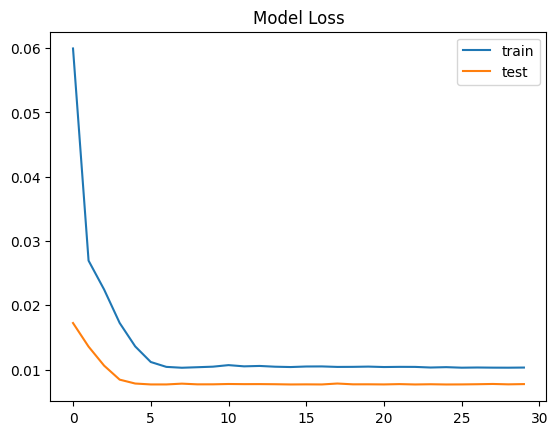

In [17]:

# design network
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model.summary()

# model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=96, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Model Loss")
plt.legend()
plt.show()



In [18]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

325/325 [==============================] - 1s 2ms/step
Test RMSE: 3.120


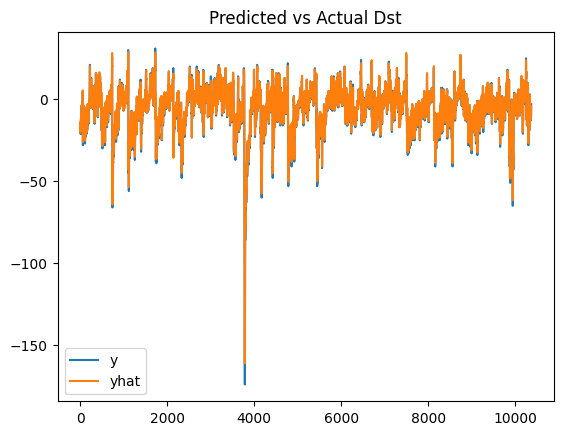

In [19]:
# pyplot.plot(inv_y, inv_yhat)
plt.plot(inv_y, label='y')
plt.plot(inv_yhat, label='yhat')
plt.title("Predicted vs Actual Dst")
plt.legend()
plt.show()
plt.show()

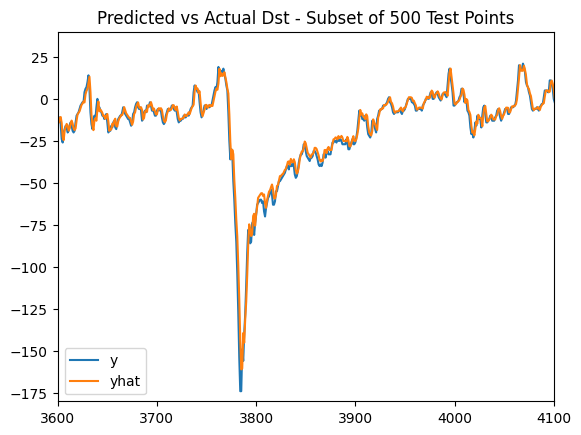

In [29]:
plt.plot(inv_y, label='y')
plt.plot(inv_yhat, label='yhat')
plt.title("Predicted vs Actual Dst - Subset of 500 Test Points")
plt.xlim([3600, 4100])
plt.ylim([-180, 40])
plt.legend()
plt.show()
